# Lab 2: Cats vs Dogs

**Deadline**: Feb 07, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Saba Ale Ebrahim -- saba.aleebrahim@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1KcByUbMoZ8CijLY2MS347__nyBiKPmtf?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

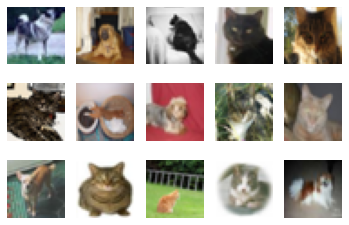

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
i = 0
for images, labels in train_loader:
  i += 1
print("Training sample size:", i)

i = 0
for images, labels in val_loader:
  i += 1
print("Validation sample size:", i)

i = 0
for images, labels in test_loader:
  i += 1
print("Testing sample size:", i)

Training sample size: 8000
Validation sample size: 2000
Testing sample size: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need our validation set to ensure that our model is learning well by giving it unbiased accuracy metrics. Validation data is not shown to the model but the model's performance on the validation is disclosed to us. 
If we judge our model on the training set data we might be overfitting our model by learning the data instead of the general patterns in the data. In other words, validation accuracy gives us the degree of generalizability of our models.

---

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
total = 0
for param in small_net.parameters():
    prod = 1
    for dim in list(param.shape):
      prod *= dim
    total += prod
    print(param.shape, prod)
print(total)

torch.Size([5, 3, 3, 3]) 135
torch.Size([5]) 5
torch.Size([1, 245]) 245
torch.Size([1]) 1
386


In [ ]:
total = 0
for param in large_net.parameters():
    prod = 1
    for dim in list(param.shape):
      prod *= dim
    total += prod
    print(param.shape, prod)
print(total)

torch.Size([5, 3, 5, 5]) 375
torch.Size([5]) 5
torch.Size([10, 5, 5, 5]) 1250
torch.Size([10]) 10
torch.Size([32, 250]) 8000
torch.Size([32]) 32
torch.Size([1, 32]) 32
torch.Size([1]) 1
9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
batch_size=64 
learning_rate=0.01
num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.427, Train loss: 0.6756271157264709 |Validation err: 0.3735, Validation loss: 0.6547912321984768
Epoch 2: Train err: 0.363875, Train loss: 0.6433806624412537 |Validation err: 0.381, Validation loss: 0.6529760453850031
Epoch 3: Train err: 0.349625, Train loss: 0.6241284198760987 |Validation err: 0.3425, Validation loss: 0.6170912720263004
Epoch 4: Train err: 0.327125, Train loss: 0.6051247277259827 |Validation err: 0.3325, Validation loss: 0.608132740482688
Epoch 5: Train err: 0.319625, Train loss: 0.5934948153495788 |Validation err: 0.3275, Validation loss: 0.6037288680672646
Finished Training
Total time elapsed: 15.88 seconds


We have 5 files, for each epoch that act like checkpoints (saved values of model weights) so we can resume from these checkpoints in the future.

We also have 4 additional files for training error, training loss, validation loss and validation error. These are csv files for us to analyze the performance of the last epoch

---

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422375, Train loss: 0.6716891074180603 |Validation err: 0.3735, Validation loss: 0.6535317860543728
Epoch 2: Train err: 0.362875, Train loss: 0.6403266997337341 |Validation err: 0.3635, Validation loss: 0.6488472539931536
Epoch 3: Train err: 0.34425, Train loss: 0.6254545783996582 |Validation err: 0.3455, Validation loss: 0.6203189175575972
Epoch 4: Train err: 0.331125, Train loss: 0.6105487518310547 |Validation err: 0.3525, Validation loss: 0.6239588130265474
Epoch 5: Train err: 0.3255, Train loss: 0.6031277022361755 |Validation err: 0.333, Validation loss: 0.6160122845321894
Epoch 6: Train err: 0.3135, Train loss: 0.5945649976730347 |Validation err: 0.3305, Validation loss: 0.6118946485221386
Epoch 7: Train err: 0.316625, Train loss: 0.5917581415176392 |Validation err: 0.3335, Validation loss: 0.6110464800149202
Epoch 8: Train err: 0.309125, Train loss: 0.58613898229599 |Validation err: 

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203123092651 |Validation err: 0.4285, Validation loss: 0.6807542946189642
Epoch 2: Train err: 0.4195, Train loss: 0.67819615650177 |Validation err: 0.413, Validation loss: 0.6741204150021076
Epoch 3: Train err: 0.39875, Train loss: 0.6658886175155639 |Validation err: 0.3925, Validation loss: 0.6518177818506956
Epoch 4: Train err: 0.373875, Train loss: 0.6490470728874207 |Validation err: 0.406, Validation loss: 0.6635930277407169
Epoch 5: Train err: 0.35375, Train loss: 0.6330237889289856 |Validation err: 0.353, Validation loss: 0.6284337677061558
Epoch 6: Train err: 0.339125, Train loss: 0.6160062110424042 |Validation err: 0.34, Validation loss: 0.6150468923151493
Epoch 7: Train err: 0.32625, Train loss: 0.6001663441658021 |Validation err: 0.335, Validation loss: 0.6086486000567675
Epoch 8: Train err: 0.313875, Train loss: 0.5828366029262543 |Validation err: 0.3325

Small net took 95.84 secs to run and large net took 112.93 secs to run. Clearly large net took more time, because it had more parameters to train

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

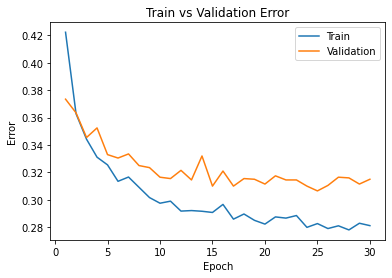

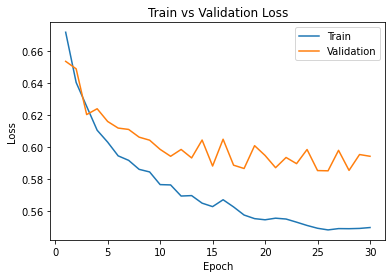

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

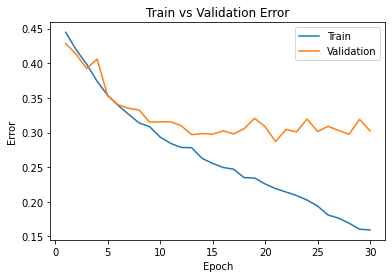

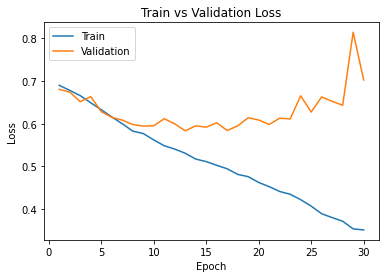

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

ANS: In the small net graphs we can see that the validation error and loss show a net decrease with more epochs as does the training error. This indicates that the model is learning. However, for the large_net the validation loss starts increasing around epoch 10, while the training loss continuous to decrease. This is clearly an indication of overfitting as the model is memorizing the training data and not effectively learning the features.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6948016662597656 |Validation err: 0.491, Validation loss: 0.6932671964168549
Epoch 2: Train err: 0.50225, Train loss: 0.6934319257736206 |Validation err: 0.491, Validation loss: 0.6924355179071426
Epoch 3: Train err: 0.50325, Train loss: 0.6926028904914856 |Validation err: 0.4935, Validation loss: 0.6918417755514383
Epoch 4: Train err: 0.48975, Train loss: 0.692021345615387 |Validation err: 0.4875, Validation loss: 0.691254859790206
Epoch 5: Train err: 0.480375, Train loss: 0.6914630241394043 |Validation err: 0.453, Validation loss: 0.690874245017767
Epoch 6: Train err: 0.4365, Train loss: 0.6908543486595153 |Validation err: 0.421, Validation loss: 0.690235199406743
Epoch 7: Train err: 0.421625, Train loss: 0.6901143398284912 |Validation err: 0.4005, Validation loss: 0.6894303094595671
Epoch 8: Train err: 0.417625, Train loss: 0.689148829460144 |Validation err: 0.3895,

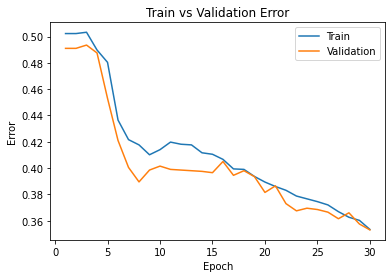

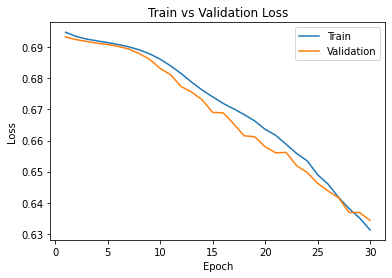

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

With a lower learning rate we see that the model learns the training data quite well and also shows a good performance on the validation data. The training time for the large net is slightly increased by 17 secs.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

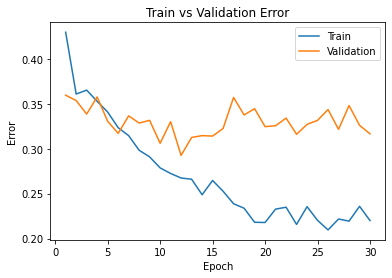

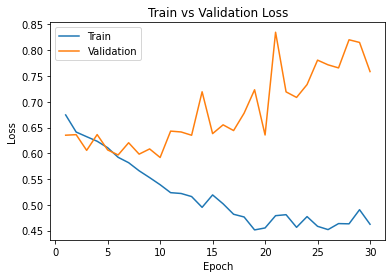

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

With a higher learning rate our model's performance deteriorates significantly. It also overfits the training data and hence is not advisable. The training time for the large net is slightly increased by 16 secs.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

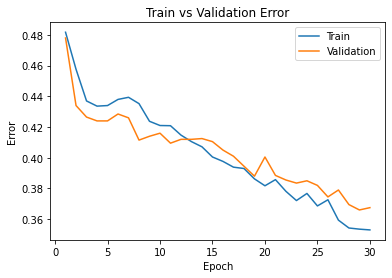

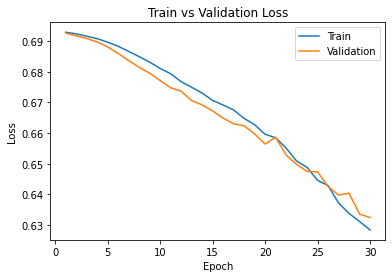

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The model does not overfit any longer and is actually learning the patterns in the data with a greater batch size. This makes sense as more images are shown to the model at a particular point in time hence making it eaasier for it to generalize. The time taken by the model is slightly less than the default model training time too!

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

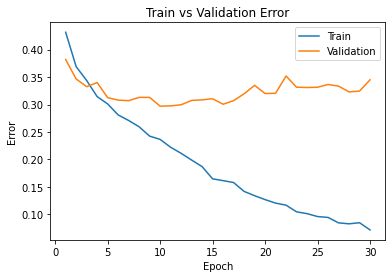

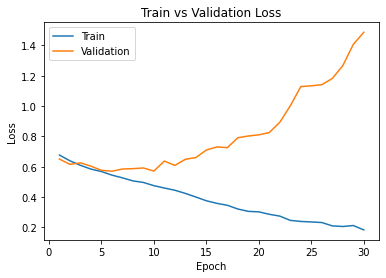

In [ ]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The model clearly takes more time to run (71 more seconds) and the batch size of 16 does not help in reducing overfitting of the model.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
network = large_net # The parameter tuning was done on larget and hence we use this network
batch_size = 512 # We saw earlier than increasing batch size resolves the issue of overfitting
learning_rate = 0.001 # A smaller learning rate also helped us prevent overfitting and reduce val loss

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

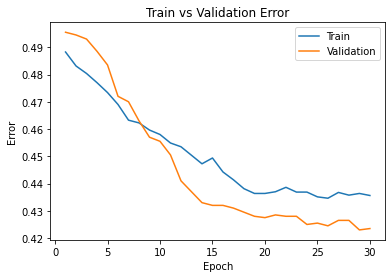

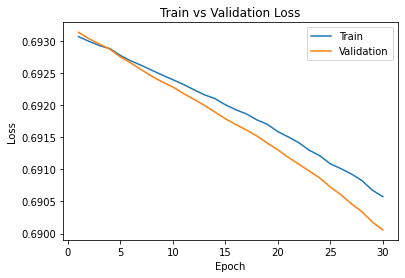

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

ANS: Clearly these combination of hyperparameters do not achieve the same performance as that obtained when they were isolated. We also notice that the train error exceeded the validation error at some point in time. This indicates that there might be a point where our learning rate was high enough to prevent the model from achieving a local minima, hence we decrease the learning rate. We also increase the number of epochs to counter the decrease in learning rate.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.0009, num_epochs=40)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.506125, Train loss: 0.6940571889281273 |Validation err: 0.516, Validation loss: 0.6941202580928802
Epoch 2: Train err: 0.5035, Train loss: 0.6939504705369473 |Validation err: 0.5105, Validation loss: 0.6939485818147659
Epoch 3: Train err: 0.500625, Train loss: 0.6937552280724049 |Validation err: 0.507, Validation loss: 0.6937750577926636
Epoch 4: Train err: 0.498, Train loss: 0.6935780979692936 |Validation err: 0.504, Validation loss: 0.6935799717903137
Epoch 5: Train err: 0.496125, Train loss: 0.6934718936681747 |Validation err: 0.4985, Validation loss: 0.693472683429718
Epoch 6: Train err: 0.495875, Train loss: 0.6933004297316074 |Validation err: 0.497, Validation loss: 0.6933056265115738
Epoch 7: Train err: 0.4945, Train loss: 0.6931582763791084 |Validation err: 0.496, Validation loss: 0.6931587755680084
Epoch 8: Train err: 0.49325, Train loss: 0.6930378936231136 |Validation err: 0.494,

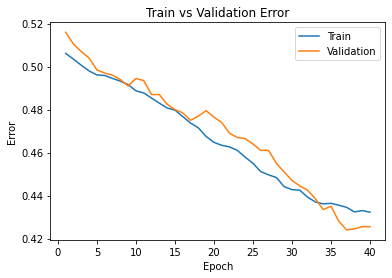

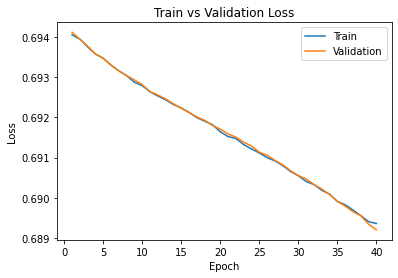

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.0009, epoch=39)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

Based on the validation loss and validation error, the large net with batch size of 512 and learning rate of 0.01 gives the 
best result (lowest loss and error)

---

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

print(evaluate(net, test_loader, nn.BCEWithLogitsLoss()))

Files already downloaded and verified
Files already downloaded and verified
(0.355, 0.6385511495172977)


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

ANS: It is slightly higher than the validation error achieved at the end of training (0.6324127316474915). We do expect it because the performance test results were shown to the model to improve upon however it had never seen the test set and hence it might not be able to produce the same accuracy (or loss)

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Using it during the training phase defeats its very purpose. It's like showing the final exam paper to a student so he performs well in the finals! Test data is used to predict how well the model behaves on 'unseen' data. The emphasis on 'unseen' suggests that it is recommended that we use it as little as possible when fine-tuning

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

pigeon = Pigeon()

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# load the data
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Grayscale()])

# Load CIFAR10 training data
mnist_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Get the list of indices to sample from
relevant_indices = get_relevant_indices(mnist_data, classes, ["cat", "dog"])

# Split into train and validation
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(relevant_indices)
split = int(len(relevant_indices) * 0.8) #split at 80%

# split into training and validation indices
relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
train_sampler = SubsetRandomSampler(relevant_train_indices)
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1,
                                            num_workers=1, sampler=train_sampler)
val_sampler = SubsetRandomSampler(relevant_val_indices)
val_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1,
                                          num_workers=1, sampler=val_sampler)

# Load CIFAR10 testing data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
# Get the list of indices to sample from
relevant_test_indices = get_relevant_indices(testset, classes, ["cat", "dog"])
test_sampler = SubsetRandomSampler(relevant_test_indices)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                        num_workers=1, sampler=test_sampler)

Files already downloaded and verified
Files already downloaded and verified


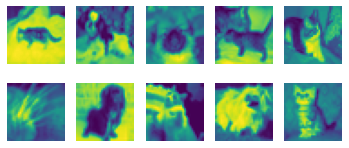

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in test_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # print(type(image), image.shape)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(np.reshape(img, (32, 32)))

    k += 1
    if k > 9:
        break

In [ ]:
# simplified training code to train `pigeon` on the "small digit recognition" task
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(pigeon.parameters(), lr=0.0001, momentum=0.9)

# Training iterations - epoch
epoch = 15

for i in range(1, epoch + 1):
  for image, label in train_loader:
      # actual ground truth: is the digit less than 3?
      actual = torch.tensor(label < 4).reshape([1,1]).type(torch.FloatTensor)
      #print(actual, label)
      # pigeon prediction
      out = pigeon(image) # step 1-2
      # update the parameters based on the loss
      loss = criterion(out, actual)      # step 3
      loss.backward()                    # step 4 (compute the updates for each parameter)
      optimizer.step()                   # step 4 (make the updates for each parameter)
      optimizer.zero_grad()              # a clean up step for PyTorch
  print("Epoch", i, "completed")

# computing the error and accuracy on the training set
error = 0
for image, label in train_loader:
    prob = torch.sigmoid(pigeon(image))
    if (prob < 0.5 and label < 4) or (prob >= 0.5 and label >= 4):
        error += 1
print("Training Error Rate:", error/len(train_loader))
print("Training Accuracy:", 1 - error/len(train_loader))

# computing the error and accuracy on a test set
error = 0
for (image, label) in val_loader:
    prob = torch.sigmoid(pigeon(image))

    if (prob < 0.5 and label < 4) or (prob >= 0.5 and label >= 4):
        error += 1
print("Test Error Rate:", error/len(val_loader))
print("Test Accuracy:", 1 - error/len(val_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Training Error Rate: 0.35025
Training Accuracy: 0.64975
Test Error Rate: 0.404
Test Accuracy: 0.596


Hyperparameter tuning:
- Default: Training Error Rate: 0.49775 |
Training Accuracy: 0.50225 |
Test Error Rate: 0.509 |
Test Accuracy: 0.491 

- Lr = 0.01: Training Error Rate: 0.50225 |
Training Accuracy: 0.49775 |
Test Error Rate: 0.491 |
Test Accuracy: 0.509

- Epochs = 5: Training Error Rate: 0.49775
Training Accuracy: 0.50225
Test Error Rate: 0.509
Test Accuracy: 0.491

- Lr = 0.0001: Training Error Rate: 0.49775
Training Accuracy: 0.50225
Test Error Rate: 0.509
Test Accuracy: 0.491

- **FINAL CHOICE:** New architecture + (epoch = 15) + lr = 0.0001: Training Error Rate: 0.35025 | 
Training Accuracy: 0.64975 |
Test Error Rate: 0.404 |
Test Accuracy: 0.596
```
def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2
```

- New architecture + epoch = 5 + Lr = 0.01: Training Error Rate: 0.49775 |
Training Accuracy: 0.50225 |
Test Error Rate: 0.509 |
Test Accuracy: 0.491

- New architechture + Lr = 0.01: Training Error Rate: 0.50225 |
Training Accuracy: 0.49775 |
Test Error Rate: 0.491 |
Test Accuracy: 0.509

- Trying yet another architechture:
```
def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        activation3 = F.relu(activation3)
        activation4 = self.layer4(activation3)
```
Training Error Rate: 0.50225 |
Training Accuracy: 0.49775 |
Test Error Rate: 0.491 |
Test Accuracy: 0.509
- Sigmoid act. func.: Training Error Rate: 0.49775 |
Training Accuracy: 0.50225 |
Test Error Rate: 0.509 |
Test Accuracy: 0.491

Testing accuracy

In [ ]:
error = 0
for (image, label) in test_loader:
    prob = torch.sigmoid(pigeon(image))
    if (prob < 0.5 and label < 4) or (prob >= 0.5 and label >= 4):
        error += 1

print("Test Error Rate:", error/len(val_loader))
print("Test Accuracy:", 1 - error/len(val_loader))

Test Error Rate: 0.393
Test Accuracy: 0.607


Conclusion: CNN is much better than ANN for image classification tasks

## END